In [2]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from elosports.elo import Elo
import time
import matplotlib.pyplot as plt



In [3]:
PL_21_team_ratings = pd.read_csv('PL21_teamratings.csv')
PL2020_keepers = pd.read_csv('PL2020_keepers.csv')
PL2020_players = pd.read_csv('PL2020_players.csv')
Fantasy_2020 = pd.read_csv('Data/2020-21/Players/FL_20.csv')
Fantasy_2020.drop(Fantasy_2020[Fantasy_2020.position != 'GK'].index, inplace=True)
#PL_21_team_ratings.drop(PL_21_team_ratings[ PL_21_team_ratings.Wk < 4].index, inplace=True)

#GK_Teams = pd.read_csv('Data/GK_Teams.csv', header=[1])
Fantasy_2020

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
3,Aaron Ramsdale,GK,Sheffield Utd,2.5,0,0,12,0,0.0,483,...,0,0.0,1,0,0,0,50,True,0,1
11,Adrián San Miguel del Castillo,GK,Liverpool,3.3,0,0,0,0,0.0,245,...,4,0.0,0,0,0,0,45,True,0,1
19,Alex McCarthy,GK,Southampton,1.8,0,0,17,0,0.0,363,...,1,0.0,2,0,0,0,45,False,0,1
23,Alisson Ramses Becker,GK,Liverpool,5.5,0,0,9,0,0.0,252,...,4,0.0,1,0,0,0,60,True,0,1
26,Alphonse Areola,GK,Fulham,0.8,0,0,0,0,0.0,516,...,0,0.0,0,0,0,0,45,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24331,Marcus Bettinelli,GK,Fulham,0.0,0,0,0,0,0.0,183,...,0,0.0,0,-7,0,7,43,True,0,38
24343,Matija Sarkic,GK,Wolves,0.0,0,0,0,0,0.0,472,...,1,0.0,0,-17,0,17,44,True,0,38
24346,David Martin,GK,West Ham,0.5,0,0,0,0,0.0,429,...,3,0.0,0,-601,6392,6993,39,True,0,38
24354,Daniel Langley,GK,Newcastle,-0.5,0,0,0,0,0.0,606,...,0,0.0,0,539,1569,1030,39,False,0,38


In [313]:
#PL2020_gk = pd.merge(PL2020_keepers, GK_Teams, on='player', how='left')
PL2020_gk = PL2020_keepers[['matchweek', 'player', 'Team', 'shots_on_target_against', 'goals_against_gk', 'saves', 'save_pct', 'psxg_gk', 'passes', 'passes_pct']]
PL2020_gk

,matchweek,player,Team,shots_on_target_against,goals_against_gk,saves,save_pct,psxg_gk,passes,passes_pct
0,1.0,Marek Rodák,Fulham,5.0,3.0,2.0,40.0,2.5,26.0,73.1
1,1.0,Bernd Leno,Arsenal,2.0,0.0,2.0,100.0,0.0,32.0,100.0
2,1.0,Vicente Guaita,Crystal Palace,5.0,0.0,5.0,100.0,0.8,26.0,26.9
3,1.0,Alex McCarthy,Southampton,3.0,1.0,2.0,66.7,0.7,51.0,76.5
4,1.0,Alisson,Liverpool,3.0,3.0,0.0,0.0,2.1,29.0,65.5
...,...,...,...,...,...,...,...,...,...,...
760,38.0,Robert Sánchez,Brighton & Hove Albion,4.0,2.0,2.0,50.0,1.1,56.0,82.1
761,38.0,Alisson,Liverpool,4.0,0.0,4.0,100.0,1.1,25.0,96.0
762,38.0,Vicente Guaita,Crystal Palace,5.0,2.0,3.0,60.0,2.2,40.0,42.5
763,38.0,Marek Rodák,Fulham,3.0,2.0,2.0,66.7,1.5,20.0,90.0


In [326]:
PL2020_gk['Rating_gk'] = ((PL2020_gk['psxg_gk'] - PL2020_gk['goals_against_gk'])*100)+(PL2020_gk['save_pct']/100*80) + (PL2020_gk['goals_against_gk']*-60)  + (PL2020_gk['passes_pct']/100*40) +(PL2020_gk['saves']*40) + (PL2020_gk['passes']*20)


OldMax = PL2020_gk['Rating_gk'].max()
OldMin = PL2020_gk['Rating_gk'].min()
NewMax = 100
NewMin = 0


OldRange = (OldMax - OldMin)
NewRange = (NewMax - NewMin)
PL2020_gk['Rating_gk'] = (((PL2020_gk['Rating_gk'] - OldMin) * NewRange) / OldRange) + NewMin

PL2020_gk['Home_id'] = PL2020_gk['Team'] + PL2020_gk['matchweek'].astype(str)
PL2020_gk['Away_id'] = PL2020_gk['Team'] + PL2020_gk['matchweek'].astype(str)
PL2020_gk['Rating_gk_home'] = PL2020_gk['Rating_gk']
PL2020_gk['Rating_gk_away'] = PL2020_gk['Rating_gk']
#PL2020_gk['Home_id'].duplicated()
PL2020_gk

,matchweek,player,Team,shots_on_target_against,goals_against_gk,saves,save_pct,psxg_gk,passes,passes_pct,Rating_gk,Home_id,Away_id,Rating_gk_home,Rating_gk_away
0,1.0,Marek Rodák,Fulham,5.0,3.0,2.0,40.0,2.5,26.0,73.1,31.665099,Fulham1.0,Fulham1.0,31.665099,31.665099
1,1.0,Bernd Leno,Arsenal,2.0,0.0,2.0,100.0,0.0,32.0,100.0,59.131837,Arsenal1.0,Arsenal1.0,59.131837,59.131837
2,1.0,Vicente Guaita,Crystal Palace,5.0,0.0,5.0,100.0,0.8,26.0,26.9,62.542669,Crystal Palace1.0,Crystal Palace1.0,62.542669,62.542669
3,1.0,Alex McCarthy,Southampton,3.0,1.0,2.0,66.7,0.7,51.0,76.5,76.196748,Southampton1.0,Southampton1.0,76.196748,76.196748
4,1.0,Alisson,Liverpool,3.0,3.0,0.0,0.0,2.1,29.0,65.5,25.278860,Liverpool1.0,Liverpool1.0,25.278860,25.278860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,38.0,Robert Sánchez,Brighton & Hove Albion,4.0,2.0,2.0,50.0,1.1,56.0,82.1,74.105631,Brighton & Hove Albion38.0,Brighton & Hove Albion38.0,74.105631,74.105631
761,38.0,Alisson,Liverpool,4.0,0.0,4.0,100.0,1.1,25.0,96.0,62.384088,Liverpool38.0,Liverpool38.0,62.384088,62.384088
762,38.0,Vicente Guaita,Crystal Palace,5.0,2.0,3.0,60.0,2.2,40.0,42.5,62.155624,Crystal Palace38.0,Crystal Palace38.0,62.155624,62.155624
763,38.0,Marek Rodák,Fulham,3.0,2.0,2.0,66.7,1.5,20.0,90.0,29.522914,Fulham38.0,Fulham38.0,29.522914,29.522914


In [327]:
gk20 = PL2020_gk.groupby(['player']).sum()['Rating_gk']
keeper_strength = gk20.sort_values(ascending=False)
keeper_strength

player
Illan Meslier             2290.804999
Emiliano Martínez         2276.685929
Sam Johnstone             2159.266228
Kasper Schmeichel         1965.233168
Alisson                   1955.535546
Aaron Ramsdale            1954.906599
Bernd Leno                1928.265018
Hugo Lloris               1893.159522
Jordan Pickford           1882.918963
Ederson                   1836.046230
Alphonse Areola           1813.253595
Robert Sánchez            1782.233571
Nick Pope                 1760.736460
Vicente Guaita            1743.206558
Łukasz Fabiański          1713.371859
Edouard Mendy             1648.730009
Alex McCarthy             1625.902432
Rui Patrício              1396.403709
Karl Darlow               1170.073915
David de Gea              1020.341352
Martin Dúbravka            720.252654
Mathew Ryan                696.702056
Dean Henderson             589.453031
Fraser Forster             423.131300
Kepa Arrizabalaga          386.646956
Robin Olsen                342.061551
Kiko 

In [10]:

fl20 = Fantasy_2020.groupby(['name']).sum()['total_points']
fl_points =  fl20.sort_values(ascending=False)
fl_points

name
Emiliano Martínez            186
Ederson Santana de Moraes    160
Illan Meslier                154
Hugo Lloris                  149
Nick Pope                    144
                            ... 
Elia Caprile                   0
Matija Sarkic                  0
Matt Macey                     0
Michael Verrips                0
Ørjan Nyland                   0
Name: total_points, Length: 80, dtype: int64

In [147]:
PL_21_team_ratings['Home_id'] = PL_21_team_ratings['HomeTeam'] + PL_21_team_ratings['Wk'].astype(str)
PL_21_team_ratings['Away_id'] = PL_21_team_ratings['AwayTeam'] + PL_21_team_ratings['Wk'].astype(str)

In [205]:
tmp = pd.merge(PL_21_team_ratings, PL2020_gk[['Home_id', 'Rating_gk_home']], on='Home_id', how='left')
out = pd.merge(tmp, PL2020_gk[['Away_id', 'Rating_gk_away']], on='Away_id', how='left')
out



,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,eloH,eloA,eloDifference,pointsH,pointsA,pointsDifference,Home_id,Away_id,Rating_gk_home,Rating_gk_away
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,1500.000000,1500.000000,0.000000,0,0,0,Fulham1.0,Arsenal1.0,40.0,105.0
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1500.000000,1500.000000,0.000000,0,0,0,Crystal Palace1.0,Southampton1.0,116.0,68.7
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,1500.000000,1500.000000,0.000000,0,0,0,Liverpool1.0,Leeds United1.0,-6.0,52.0
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,1500.000000,1500.000000,0.000000,0,0,0,West Ham1.0,Newcastle Utd1.0,38.3,115.0
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,1500.000000,1500.000000,0.000000,0,0,0,West Brom1.0,Leicester City1.0,87.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,1572.195622,1458.109252,114.086370,66,44,22,Liverpool38.0,Crystal Palace38.0,118.0,68.0
384,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,1629.646004,1521.033816,108.612188,83,59,24,Manchester City38.0,Everton38.0,110.0,60.5
385,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,1362.194200,1452.510491,-90.316291,20,39,-19,Sheffield Utd38.0,Burnley38.0,107.0,62.7
386,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,1551.974233,1441.808453,110.165781,62,43,19,West Ham38.0,Southampton38.0,118.0,52.1


In [149]:
def get_points(team, wk):
    for index, row in out.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk'] == wk and row['HomeTeam'] == team:
            return row['Rating_gk_home']
        elif row['Wk'] == wk and row['AwayTeam'] == team:
            return row['Rating_gk_away']

def get_points_season(team, fr, to):
    out = 0
    for i in range(fr,to):
        out = out + get_points(team, i)

    return out


def append_form(timespan):
    formH = []
    formA = []
    for index, row in out.iterrows():
        wk = row['Wk']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk) - timespan < 1:
            pointsH = get_points_season(teamH, 1, int(wk))
            pointsA = get_points_season(teamA, 1, int(wk))
        else:
            pointsH = get_points_season(teamH, int(wk)-timespan, int(wk))
            pointsA = get_points_season(teamA, int(wk)-timespan, int(wk))
        formH.append(pointsH)
        formA.append(pointsA)
    out['form_keeper_h'] = formH
    out['form_keeper_a'] = formA

append_form(5)

In [150]:
out.to_csv('PL20_allData.csv',index=False)

In [151]:
PL_20 = out[['Wk', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'Rating_Home', 'Rating_Away', 'Rating difference', 'form5GamesH', 'form5GamesA', 'form5GamesDifference', 'eloH', 'eloA', 'eloDifference', 'Rating_gk_home', 'Rating_gk_away', 'form_keeper_h', 'form_keeper_a']]
PL_20

,Wk,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Rating_Home,Rating_Away,Rating difference,form5GamesH,form5GamesA,form5GamesDifference,eloH,eloA,eloDifference,Rating_gk_home,Rating_gk_away,form_keeper_h,form_keeper_a
0,1.0,Fulham,Arsenal,A,0,3,69.939394,76.212121,-6.272727,0,0,0,1500.000000,1500.000000,0.000000,40.0,105.0,0.0,0.0
1,1.0,Crystal Palace,Southampton,H,1,0,71.454545,71.303030,0.151515,0,0,0,1500.000000,1500.000000,0.000000,116.0,68.7,0.0,0.0
2,1.0,Liverpool,Leeds United,H,4,3,78.575758,67.969697,10.606061,0,0,0,1500.000000,1500.000000,0.000000,-6.0,52.0,0.0,0.0
3,1.0,West Ham,Newcastle Utd,A,0,2,71.303030,73.272727,-1.969697,0,0,0,1500.000000,1500.000000,0.000000,38.3,115.0,0.0,0.0
4,1.0,West Brom,Leicester City,A,0,3,68.718750,75.151515,-6.432765,0,0,0,1500.000000,1500.000000,0.000000,87.0,105.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,38.0,Liverpool,Crystal Palace,H,2,0,78.575758,71.454545,7.121212,13,6,7,1572.195622,1458.109252,114.086370,118.0,68.0,379.7,136.3
384,38.0,Manchester City,Everton,H,5,0,77.484848,74.393939,3.090909,9,9,0,1629.646004,1521.033816,108.612188,110.0,60.5,341.3,380.4
385,38.0,Sheffield Utd,Burnley,H,1,0,69.935484,70.166667,-0.231183,6,6,0,1362.194200,1452.510491,-90.316291,107.0,62.7,483.0,261.3
386,38.0,West Ham,Southampton,H,3,0,71.303030,71.303030,0.000000,7,4,3,1551.974233,1441.808453,110.165781,118.0,52.1,428.0,344.1


In [171]:
pd.set_option('display.max_rows', PL_20.shape[0]+1)
PL_20.dropna(inplace=True)
PL_20

C:\Users\giuli\AppData\Local\Temp\ipykernel_14324\1153863287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PL_20.dropna(inplace=True)


,Wk,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Rating_Home,Rating_Away,Rating difference,form5GamesH,form5GamesA,form5GamesDifference,eloH,eloA,eloDifference,Rating_gk_home,Rating_gk_away,form_keeper_h,form_keeper_a,identifier
0,1.0,Fulham,Arsenal,A,0,3,69.939394,76.212121,-6.272727,0,0,0,1500.000000,1500.000000,0.000000,40.0,1.050000e+02,0.0,0.0,1
1,1.0,Crystal Palace,Southampton,H,1,0,71.454545,71.303030,0.151515,0,0,0,1500.000000,1500.000000,0.000000,116.0,6.870000e+01,0.0,0.0,0
2,1.0,Liverpool,Leeds United,H,4,3,78.575758,67.969697,10.606061,0,0,0,1500.000000,1500.000000,0.000000,-6.0,5.200000e+01,0.0,0.0,0
3,1.0,West Ham,Newcastle Utd,A,0,2,71.303030,73.272727,-1.969697,0,0,0,1500.000000,1500.000000,0.000000,38.3,1.150000e+02,0.0,0.0,1
4,1.0,West Brom,Leicester City,A,0,3,68.718750,75.151515,-6.432765,0,0,0,1500.000000,1500.000000,0.000000,87.0,1.050000e+02,0.0,0.0,1
5,1.0,Tottenham,Everton,A,0,1,77.242424,74.393939,2.848485,0,0,0,1500.000000,1500.000000,0.000000,82.0,1.140000e+02,0.0,0.0,1
6,1.0,Brighton,Chelsea,A,1,3,70.787879,79.212121,-8.424242,0,0,0,1500.000000,1500.000000,0.000000,42.0,6.370000e+01,0.0,0.0,1
7,1.0,Sheffield Utd,Wolves,A,0,2,69.935484,69.636364,0.299120,0,0,0,1500.000000,1500.000000,0.000000,39.0,1.040000e+02,0.0,0.0,1
8,2.0,Everton,West Brom,H,5,2,74.393939,68.718750,5.675189,3,0,3,1512.801300,1487.198700,25.602600,40.0,2.460000e+01,114.0,87.0,0
9,2.0,Leeds United,Fulham,H,4,3,67.969697,69.939394,-1.969697,0,0,0,1492.801300,1487.198700,5.602600,56.0,4.600000e+01,52.0,40.0,0


In [197]:
#add column for H A X

y = PL_20['identifier'].to_numpy()
feature_name = ['Rating_Away','Rating_Home' ,'Rating difference', 'form5GamesH', 'form5GamesA', 'form5GamesDifference', 'eloH', 'eloA', 'eloDifference', 'Rating_gk_home', 'Rating_gk_away', 'form_keeper_h', 'form_keeper_a']
X = PL_20[feature_name].to_numpy()
#X = PL_21_team_ratings[['Rating difference', 'eloA', 'eloDifference' ]].to_numpy()
PL_20

,Wk,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Rating_Home,Rating_Away,Rating difference,form5GamesH,form5GamesA,form5GamesDifference,eloH,eloA,eloDifference,Rating_gk_home,Rating_gk_away,form_keeper_h,form_keeper_a,identifier
0,1.0,Fulham,Arsenal,A,0,3,69.939394,76.212121,-6.272727,0,0,0,1500.000000,1500.000000,0.000000,40.0,1.050000e+02,0.0,0.0,1
1,1.0,Crystal Palace,Southampton,H,1,0,71.454545,71.303030,0.151515,0,0,0,1500.000000,1500.000000,0.000000,116.0,6.870000e+01,0.0,0.0,0
2,1.0,Liverpool,Leeds United,H,4,3,78.575758,67.969697,10.606061,0,0,0,1500.000000,1500.000000,0.000000,-6.0,5.200000e+01,0.0,0.0,0
3,1.0,West Ham,Newcastle Utd,A,0,2,71.303030,73.272727,-1.969697,0,0,0,1500.000000,1500.000000,0.000000,38.3,1.150000e+02,0.0,0.0,1
4,1.0,West Brom,Leicester City,A,0,3,68.718750,75.151515,-6.432765,0,0,0,1500.000000,1500.000000,0.000000,87.0,1.050000e+02,0.0,0.0,1
5,1.0,Tottenham,Everton,A,0,1,77.242424,74.393939,2.848485,0,0,0,1500.000000,1500.000000,0.000000,82.0,1.140000e+02,0.0,0.0,1
6,1.0,Brighton,Chelsea,A,1,3,70.787879,79.212121,-8.424242,0,0,0,1500.000000,1500.000000,0.000000,42.0,6.370000e+01,0.0,0.0,1
7,1.0,Sheffield Utd,Wolves,A,0,2,69.935484,69.636364,0.299120,0,0,0,1500.000000,1500.000000,0.000000,39.0,1.040000e+02,0.0,0.0,1
8,2.0,Everton,West Brom,H,5,2,74.393939,68.718750,5.675189,3,0,3,1512.801300,1487.198700,25.602600,40.0,2.460000e+01,114.0,87.0,0
9,2.0,Leeds United,Fulham,H,4,3,67.969697,69.939394,-1.969697,0,0,0,1492.801300,1487.198700,5.602600,56.0,4.600000e+01,52.0,40.0,0


In [198]:
X_train21 = np.split(X,[40, 340, 380], axis=0)
X_train2 = X_train21[1]
X_test2 = X_train21[2]
y_train21 = np.split(y,[40, 340, 380], axis=0)
y_train2 = y_train21[1]
y_test2 = y_train21[2]

In [199]:
print(f'X_train2 : {X_train2.shape}')
print(f'y_train2 : {y_train2.shape}')
print(f'X_test2 : {X_test2.shape}')
print(f'y_test2 : {y_test2.shape}')

X_train2 : (300, 13)
y_train2 : (300,)
X_test2 : (35, 13)
y_test2 : (35,)


In [200]:
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier(seed = 82)

In [201]:
rf_model.fit(X_train2, y_train2)
xgb_model.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=82, reg_alpha=0, ...)

In [202]:
rf_model.score(X_test2, y_test2)

0.7142857142857143

In [203]:
xgb_model.score(X_test2, y_test2)

0.6857142857142857

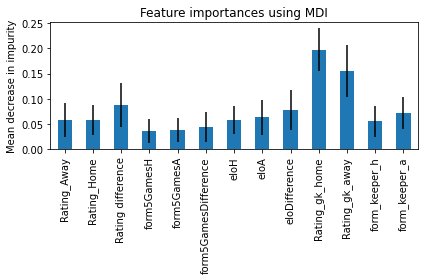

In [204]:
start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_name)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()